# Ön Bilgi
**Geliştirenler :** Onur Kantar - Ömer Resul Ertan

**Veri Kümesinin İçeriği :** 3 farklı sınıfa ait toplamda 3000 tweet bulunmaktadır.

**Tweet Sınıfları :** 

-	Olumlu Tweetler
-	Olumsuz Tweetler
-	Nötr Tweetler

**Veri Kümesi Referansı :** "Eğiticili ve Geleneksel Terim Ağırlıklandırma Yöntemleriyle Duygu Analizi", Mahmut Çetin, M.Fatih Amasyalı, SIU 2013, KKTC

**Algoritma :** GloVe

**Ağ Mimarisi :** 

- Embedding(150)
- LSTM(150)
- Dense(3)

batch_size = 16

epochs = 3

~%87 doğruluk oranı elde ediliyor.

In [1]:
pip install glove-python

In [2]:
import pandas as pd
from nltk.corpus import stopwords
import re
import nltk
from gensim.models.word2vec import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns
from glove import Corpus, Glove
import random
import numpy as np
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, Dropout
from keras.initializers import Constant
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Veri Kümemizi Ekleyelim : 

---



In [3]:
tweets = pd.read_csv("/content/drive/My Drive/Colab Notebooks/3000tweet.csv", sep=';', encoding="utf8")
tweets

,tweet,durum
0,dun Turkcelle tepkilerimizden sonra bugün Turk...,1
1,girmezmiyim.. Turkcell kartim bile var.. Yarin...,1
2,tam tünelden gecerken 3g cekiyordu :D türkcell...,1
3,turkcell superonline fiber internet veya ADSL ...,1
4,bence Gnçtrkcll Ark Winterfest 2012'de 1.olur ...,1
...,...,...
2995,Evet kesinlikle çok az.. Turkcell bu konuda şu...,3
2996,selocan nedir abicim ya ?,3
2997,özturkcell e dönücz diye korkuyorum ama çanakk...,3
2998,turkcell se 532 yi ara puk kodunu ogrenme menu...,3


# Veri Kümemizi Düzenleyelim : 

---



### NULL Değerleri Silme İşlemi : 

In [4]:
tweets.isnull().sum()

tweet    1
durum    0
dtype: int64

In [5]:
tweets = tweets.dropna().reset_index(drop=True)
tweets.isnull().sum()

tweet    0
durum    0
dtype: int64

### Gereksiz Kelimeleri - Boşukları - İşaretleri Silme İşlemleri :  

In [6]:
nltk.download('stopwords')
stop_word_list = stopwords.words('turkish')
stop_word_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba',
 'ama',
 'aslında',
 'az',
 'bazı',
 'belki',
 'biri',
 'birkaç',
 'birşey',
 'biz',
 'bu',
 'çok',
 'çünkü',
 'da',
 'daha',
 'de',
 'defa',
 'diye',
 'eğer',
 'en',
 'gibi',
 'hem',
 'hep',
 'hepsi',
 'her',
 'hiç',
 'için',
 'ile',
 'ise',
 'kez',
 'ki',
 'kim',
 'mı',
 'mu',
 'mü',
 'nasıl',
 'ne',
 'neden',
 'nerde',
 'nerede',
 'nereye',
 'niçin',
 'niye',
 'o',
 'sanki',
 'şey',
 'siz',
 'şu',
 'tüm',
 've',
 'veya',
 'ya',
 'yani']

In [0]:
def preprocess_text(sen):
    
    # Sayıları Silme İşlemi
    sentence = re.sub('[\d\s]', ' ', str(sen))

    # Noktalama İşaretlerini Silme İşlemi
    sentence = re.sub('[^\w\s]', ' ', str(sentence))
    
    # Tek Karakterleri Silme İşlemi
    sentence = re.sub(r"\b[\w\s]\b", ' ', str(sentence))
    
    # Birden Çok Boşluğu Silme İşlemi
    sentence = re.sub(r'\s+', ' ', sentence)
        
    # Engellenecek Kelimeleri Silme İşlemi
    WPT = nltk.WordPunctTokenizer()
    tokens = WPT.tokenize(sentence)
    filtered_tokens = [token for token in tokens if token not in stop_word_list]
    single_doc = ' '.join(filtered_tokens)
    
    # Tüm Harfler Küçük Harfe Dönüştürülüyor
    return single_doc.lower()

In [0]:
x = tweets['tweet']
y = tweets['durum']

In [9]:
x = x.apply(preprocess_text)
pd.DataFrame(data=x)

,tweet
0,dun turkcelle tepkilerimizden sonra bugün turk...
1,girmezmiyim turkcell kartim bile var yarindan ...
2,tam tünelden gecerken cekiyordu türkcell in re...
3,turkcell superonline fiber internet adsl sabit...
4,bence gnçtrkcll ark winterfest olur gelir
...,...
2994,evet kesinlikle turkcell konuda an uygun değil...
2995,selocan nedir abicim
2996,özturkcell dönücz korkuyorum çanakkale holding...
2997,turkcell se yi ara puk kodunu ogrenme menusund...


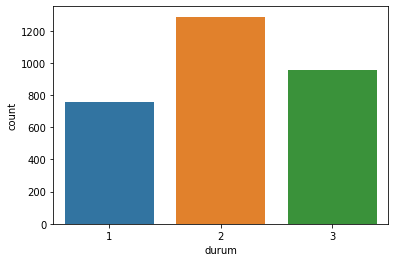

In [10]:
sns.countplot(y)

# Kelimeleri Ayırıp Sayılara Dönüştürelim : 



In [11]:
words = []
for i in x:
    words.append(i.split())

print(words[0])

['dun', 'turkcelle', 'tepkilerimizden', 'sonra', 'bugün', 'turkcell', 'twittera', 'sponsor', 'olmuş', 'ne', 'tesadüf', 'değil', 'mi']


**Veri setimizin işlenebilmesi için text verileri numaralara çevirmemiz gerekir.**


In [12]:
tokenizer_obj = Tokenizer()
# Her kelimenin sıklığını hesaplar
tokenizer_obj.fit_on_texts(x)
# Tüm kelimeleri sayı dizisine dönüştürür
x = tokenizer_obj.texts_to_sequences(x)
# Bütün metinlerimiz en uzun kelimeden oluşan metnimiz kadar sütundan oluşan (23) bir dizi ile temsil edilecek.
# 23'den kısa metinlerin boşlukları 0'lar ile doldurulacak.
x = pad_sequences(x)

pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
2858,0,0,0,0,0,0,0,0,0,11281,11282,11283,3085,20,2988,119,714,1743,11284,714,380,2,1741
1038,0,0,0,0,0,0,0,5787,5788,2,5789,5790,5791,5792,128,5793,5794,5795,111,2,20,529,47
277,0,0,0,0,0,0,0,0,222,1335,2,3806,33,1336,1337,3807,93,275,6,107,488,1966,3808
2790,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,11080,1,77,11081,70,11082
1111,0,0,0,0,0,0,0,0,0,0,0,0,230,32,423,1367,35,54,6039,1,10,6040,6041


**Verilerimizi Ölçeklendirelim**

In [13]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

pd.DataFrame(x).sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
347,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.321374,-0.365379,-0.414129,0.305282,0.942752,0.888341,0.779446,-0.594813,-0.621274,-0.662134,0.500555,0.445133,-0.647758,-0.685373
386,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.321374,-0.365379,-0.414129,-0.460660,-0.483752,-0.514478,0.813528,-0.581437,-0.596860,-0.645938,-0.284393,-0.418178,0.338667,0.287945
686,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.321374,-0.365379,-0.414129,-0.460660,-0.483752,-0.514478,-0.556821,-0.597097,0.885729,-0.662745,0.743847,0.680422,0.535616,-0.827878
1008,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.013032,2.651015,-0.317449,2.150892,-0.361646,-0.444315,-0.265704,-0.514123,1.360857,1.257258,-0.302625,-0.648994,1.022240,0.949658,-0.741065,-0.170463
2326,-0.018319,-0.022991,-0.033498,-0.042654,-0.075303,-0.119129,-0.167608,-0.225485,-0.279964,-0.321374,-0.365379,-0.414129,-0.460660,-0.483752,-0.514478,-0.556821,-0.549466,-0.440865,-0.580540,-0.686853,-0.714045,-0.703910,1.861620


In [0]:
# Kelime hazinesi belirlendi
embeddings_index = {};
word_index = tokenizer_obj.word_index

# Y Verilerimizi One Hot Encoding Uygulamamız Gerekiyor :  

In [15]:
pd.DataFrame(y).sample(5)

,durum
1486,2
2123,3
385,1
265,1
2187,3


In [16]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
pd.DataFrame(y).sample(5)

,0
1553,1
1084,1
1545,1
2286,2
2282,2


In [17]:
y = to_categorical(y)
pd.DataFrame(y).sample(5)

,0,1,2
678,1.0,0.0,0.0
945,0.0,1.0,0.0
962,0.0,1.0,0.0
2714,0.0,0.0,1.0
1314,0.0,1.0,0.0


# Kelimelerimizin Vektörlerini Oluşturalım :

In [0]:
# Corpus nesnesi oluşturduk
corpus = Corpus()
# Corpusu GloVe ile eğittik
corpus.fit(words, window=10)
# Glove objesi oluşturduk
glove = Glove(no_components=5, learning_rate=0.05)

glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=False)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

In [0]:
# Kelimeler ile vektörlerini birleştirelim
for word, i in glove.dictionary.items():
    glove.dictionary[word] = glove.word_vectors[i]

In [20]:
dict(random.sample(glove.dictionary.items(), 5))

{'eknet': array([-0.06184435, -0.02722235,  0.03314401, -0.06019981, -0.02073278]),
 'gbi': array([-0.05745236,  0.05780082,  0.04465326, -0.11745669,  0.16146397]),
 'i̇zmir': array([ 0.01469336,  0.03112586, -0.0178289 , -0.04420317,  0.03542576]),
 'yarismasindaydim': array([-0.03802893,  0.10809029, -0.07369565,  0.07397686,  0.01482626]),
 'şahsiyetsiz': array([-0.07660798,  0.04825613, -0.04465591, -0.06499813, -0.12499514])}

In [0]:
'''
with open('glove.6B.100d.txt' , encoding='utf-8') as f:
'''    

for line, i in glove.dictionary.items():
    word = line;
    coefs = np.asarray(i, dtype='float32');
    embeddings_index[word] = coefs;

vocab_size = len(word_index)+1

embeddings_matrix = np.zeros((vocab_size, 5));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Katmanları Oluşturup Eğitime Başlayalım : 

---



In [23]:
model = Sequential()

model.add(Embedding(vocab_size, 5, trainable = True, weights=[embeddings_matrix]))
model.add(LSTM(128))
model.add(Dense(3, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2399 samples, validate on 600 samples
Epoch 1/3
2399/2399 [==============================] - 5s 2ms/step - loss: 0.4831 - acc: 0.7507 - val_loss: 0.3844 - val_acc: 0.8383
Epoch 2/3
2399/2399 [==============================] - 4s 2ms/step - loss: 0.3595 - acc: 0.8288 - val_loss: 0.3257 - val_acc: 0.8500
Epoch 3/3
2399/2399 [==============================] - 4s 2ms/step - loss: 0.3239 - acc: 0.8460 - val_loss: 0.2985 - val_acc: 0.8733


In [24]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.2985493969917297
Test accuracy: 0.8733333349227905


# Sonuçları Değerlendirelim : 

---



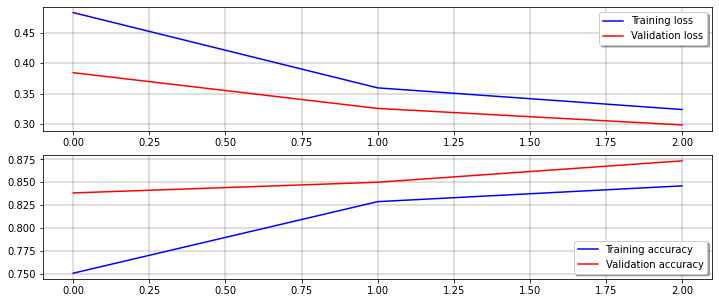

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(12,5))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

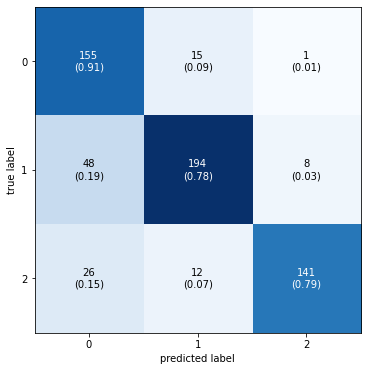

In [26]:
y_pred = model.predict(x_test)

y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_class, y_pred_class)

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_normed=True,
                                figsize =(6,6))